In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
from plotly.subplots import make_subplots
import plotly.express as px
from datetime import date,timedelta
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import h3

**Данные: обзор уровня самоубийств с 1985 по 2016 год**

In [2]:
df = pd.read_csv('master.csv')

In [3]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [5]:
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


In [6]:
df['year'].value_counts()

2009    1068
2010    1056
2001    1056
2000    1032
2011    1032
2007    1032
2002    1032
2003    1032
2006    1020
2008    1020
2005    1008
2004    1008
1999     996
2012     972
2013     960
1998     948
1995     936
2014     936
1997     924
1996     924
1994     816
1992     780
1993     780
1991     768
1990     768
2015     744
1987     648
1989     624
1988     588
1986     576
1985     576
2016     160
Name: year, dtype: int64

*Можно не учитывать 2016 год, так как судя по кол-ву самоубийств, они не полные*

In [7]:
df = df[df['year'] != 2016]

In [8]:
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27660.000000,27660.000000,2.766000e+04,27660.000000,8364.000000,27660.000000
mean,2001.173102,243.413485,1.850689e+06,12.812597,0.776601,16815.568330
std,8.418754,904.490185,3.920658e+06,18.972063,0.093367,18861.585497
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1994.000000,3.000000,9.753525e+04,0.910000,0.713000,3436.000000
50%,2002.000000,25.000000,4.307250e+05,5.980000,0.779000,9283.000000
75%,2008.000000,132.000000,1.491041e+06,16.602500,0.855000,24796.000000
max,2015.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


In [9]:
df['generation'].value_counts()

Generation X       6376
Silent             6332
Millenials         5780
Boomers            4958
G.I. Generation    2744
Generation Z       1470
Name: generation, dtype: int64

In [10]:
df['country'].value_counts()#всего 101 страна, но не у всех стран есть данные за годы

Argentina                 372
Israel                    372
Japan                     372
Puerto Rico               372
Mexico                    372
                         ... 
San Marino                 36
Bosnia and Herzegovina     24
Cabo Verde                 12
Dominica                   12
Macau                      12
Name: country, Length: 100, dtype: int64

In [11]:
df['sex'].value_counts()

female    13830
male      13830
Name: sex, dtype: int64

In [12]:
df['age'].value_counts()

15-24 years    4610
5-14 years     4610
75+ years      4610
25-34 years    4610
35-54 years    4610
55-74 years    4610
Name: age, dtype: int64

Давайте найдем суммарное кол-во самоубийств и максимальное значение, а также определим страну с макс. числом самоубийств, но также стоит учитывать и кол-во населения.

In [13]:
df['suicides_no'].sum()

6732817

In [14]:
df['suicides_no'].max()

22338

In [15]:
print(df[df['suicides_no'] ==22338]['country'],'\n',df[df['suicides_no'] ==22338]['year'])

20996    Russian Federation
Name: country, dtype: object 
 20996    1994
Name: year, dtype: int64


In [16]:
df[df['year'] ==1985]['suicides_no'].sum()

116063

Для начала посторим график по кол-ву смертей

C:\Users\genna\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



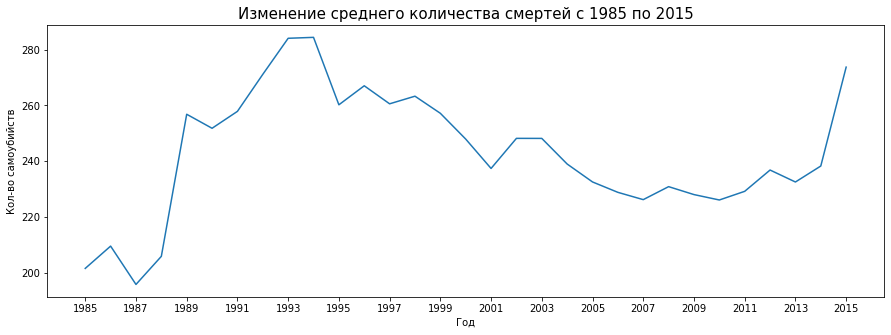

In [17]:
plt.figure(figsize=(15,5))

ax = sns.lineplot(df['year'], df['suicides_no'], ci = None)
plt.title('Изменение среднего количества смертей с 1985 по 2015', fontsize = 15)
plt.xlabel('Год')
plt.xticks(range(1985,2016, 2))
plt.ylabel('Кол-во самоубийств')
plt.show()

Как видим, наибольшие кол-во смертей резко возросло с 1987 по 1993, потом спало. С 2014 по 2015 так же заметен рост смертей.

In [18]:
a = df.groupby('country')['suicides_no'].sum()#выпишем для каждой страны кол-во смертей
a.sort_values()

country
Saint Kitts and Nevis          0
Dominica                       0
San Marino                     4
Antigua and Barbuda           11
Maldives                      20
                          ...   
Ukraine                   319950
France                    329127
Japan                     806902
United States            1034013
Russian Federation       1209742
Name: suicides_no, Length: 100, dtype: int64

In [19]:
df[df['country'] == 'Russian Federation']['year'].unique()

array([1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015], dtype=int64)

In [20]:
df[df['country'] == 'United States']['year'].unique()

array([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype=int64)

In [21]:
mean_world_s = df.groupby('year')['suicides/100k pop'].mean()#Среднее значение самоубийств на 100к людей по годам в мире

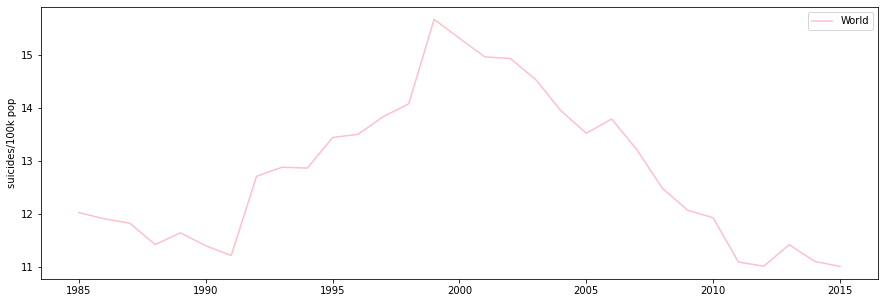

In [22]:
fig = plt.figure(figsize=(15,5))
ax = sns.lineplot(x=df['year'].unique(),y = mean_world_s, label = 'World', color = 'pink')

Text(0.5, 1.0, 'Средние значение отношения кол-ва смертей/кол-во населения в мире')

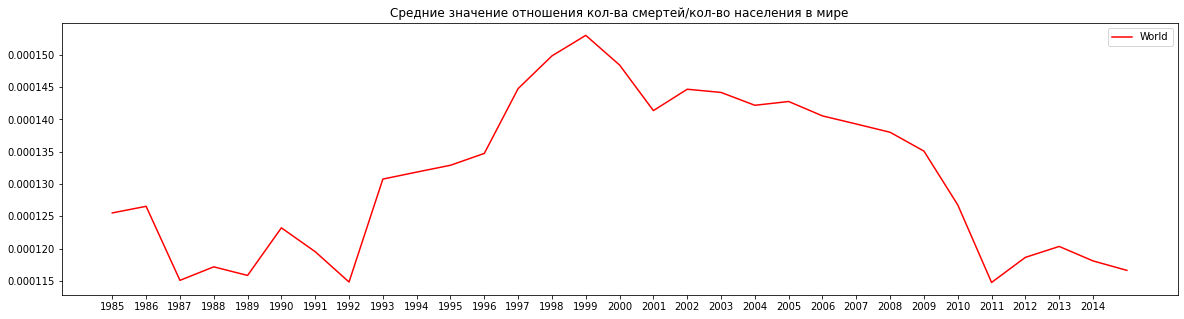

In [23]:
mean_world_s1 = (df.groupby('year')['suicides_no'].sum()/df.groupby('year')['population'].sum()).groupby('year').mean()
fig = plt.figure(figsize=(20,5))
ax = sns.lineplot(x=df['year'].unique(),y = mean_world_s1, label = 'World', color = 'red')
plt.xticks(range(1985,2015, 1))
plt.title('Средние значение отношения кол-ва смертей/кол-во населения в мире')

C:\Users\genna\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='year', ylabel='gdp_per_capita ($)'>

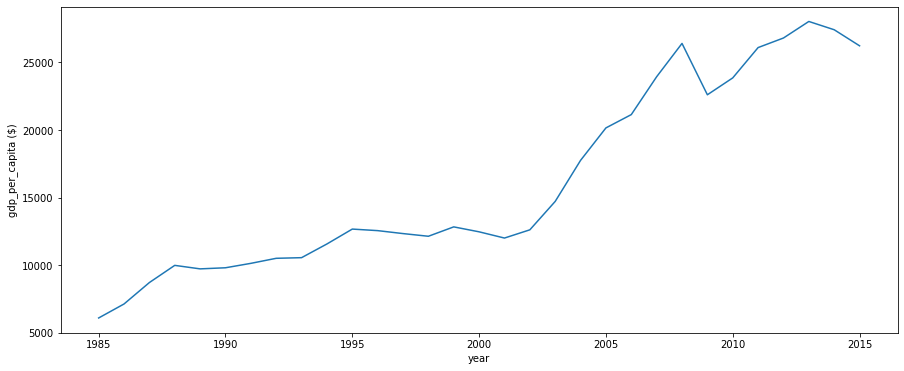

In [24]:
plt.figure(figsize=(15,6))
sns.lineplot(df['year'], df['gdp_per_capita ($)'], ci = None)

**Разделим страны на сегменты по ввп относительно каждого года, а также попробуем разделить страны на уровни риска самоубийств.**

In [25]:
a = []
for i in df.iloc[:, 9]:
    a.append(int(i.replace(',','')))

In [26]:
df['gdp_for_year'] = a

In [27]:
df.iloc[:, 9].name

' gdp_for_year ($) '

In [28]:
df = df.drop([' gdp_for_year ($) ', 'HDI for year'], axis = 1)

In [29]:
df.describe()

,year,suicides_no,population,suicides/100k pop,gdp_per_capita ($),gdp_for_year
count,27660.000000,27660.000000,2.766000e+04,27660.000000,27660.000000,2.766000e+04
mean,2001.173102,243.413485,1.850689e+06,12.812597,16815.568330,4.471009e+11
std,8.418754,904.490185,3.920658e+06,18.972063,18861.585497,1.457574e+12
min,1985.000000,0.000000,2.780000e+02,0.000000,251.000000,4.691962e+07
25%,1994.000000,3.000000,9.753525e+04,0.910000,3436.000000,8.976208e+09
50%,2002.000000,25.000000,4.307250e+05,5.980000,9283.000000,4.801361e+10
75%,2008.000000,132.000000,1.491041e+06,16.602500,24796.000000,2.602024e+11
max,2015.000000,22338.000000,4.380521e+07,224.970000,126352.000000,1.812071e+13


In [30]:
label=[1, 2, 3, 4, 5]

In [31]:
df['gdpy_rating'] = pd.qcut(df['gdp_for_year'], q = 5, labels = label, precision = 0)

In [32]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,gdp_per_capita ($),generation,gdp_for_year,gdpy_rating
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,796,Generation X,2156624900,1
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,796,Silent,2156624900,1
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,796,Generation X,2156624900,1
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,796,G.I. Generation,2156624900,1
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,796,Boomers,2156624900,1


In [34]:
df['gdpc_rating'] = pd.qcut(df['gdp_per_capita ($)'], q = 5, labels = label, precision = 0)

In [35]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,gdp_per_capita ($),generation,gdp_for_year,gdpy_rating,gdpc_rating
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,796,Generation X,2156624900,1,1
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,796,Silent,2156624900,1,1
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,796,Generation X,2156624900,1,1
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,796,G.I. Generation,2156624900,1,1
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,796,Boomers,2156624900,1,1


In [36]:
df1 = df.groupby('country').agg({'gdp_for_year': 'mean', 'gdp_per_capita ($)': 'mean', 'suicides_no' : 'mean', 'population' : 'mean', 'suicides/100k pop' : 'mean'})
df1['s/p'] = df1['suicides_no']/df1['population']
df1 = df1.sort_values(by = ['s/p'], ascending = False)
df1.head(10)

,gdp_for_year,gdp_per_capita ($),suicides_no,population,suicides/100k pop,s/p
country,,,,,,
Lithuania,2.711290e+10,9024.142857,108.003968,2.604758e+05,40.583968,0.000415
Russian Federation,8.843229e+11,6518.814815,3733.771605,1.139137e+07,34.892377,0.000328
Sri Lanka,1.532645e+10,904.272727,421.522727,1.382770e+06,35.295152,0.000305
Belarus,3.067641e+10,3333.904762,237.666667,7.832234e+05,31.075913,0.000303
Hungary,8.831404e+10,9234.120000,240.433333,8.008463e+05,33.049100,0.000300
Latvia,1.831660e+10,8961.095238,50.674603,1.779867e+05,29.259325,0.000285
Kazakhstan,7.868722e+10,5329.115385,325.467949,1.209980e+06,30.511282,0.000269
Slovenia,3.590006e+10,18642.238095,42.123016,1.597961e+05,27.827857,0.000264
Estonia,1.444586e+10,11376.095238,27.912698,1.075032e+05,27.276905,0.000260


In [37]:
df1['gdpy_rating'] = pd.qcut(df1['gdp_for_year'], q = 5, labels = label, precision = 0)

In [38]:
df1['gdpc_rating'] = pd.qcut(df1['gdp_per_capita ($)'], q = 5, labels = label, precision = 0)

In [39]:
df1.describe()

,gdp_for_year,gdp_per_capita ($),suicides_no,population,suicides/100k pop,s/p
count,1.000000e+02,100.000000,100.000000,1.000000e+02,100.000000,100.000000
mean,3.571953e+11,16019.648079,201.053164,1.573559e+06,11.969025,0.000109
std,1.187764e+12,16401.643270,526.965795,3.149497e+06,9.373299,0.000087
min,5.928353e+07,720.730769,0.000000,2.189583e+03,0.000000,0.000000
25%,7.513043e+09,4094.616071,3.825000,8.198281e+04,4.519991,0.000040
50%,3.351264e+10,8895.066138,37.014484,3.769227e+05,10.327782,0.000081
75%,2.148282e+11,26027.938640,137.520601,1.217379e+06,17.424643,0.000156
max,1.051071e+13,68798.387097,3733.771605,2.165061e+07,40.583968,0.000415


In [40]:
labelr = ['Низкий','Ниже среднего','Средний','Высокий', 'Очень высокий']
df1['suicides_rating'] = pd.qcut(df1['s/p'], q = 5, labels = labelr, precision = 0)

In [41]:
df1.head()

,gdp_for_year,gdp_per_capita ($),suicides_no,population,suicides/100k pop,s/p,gdpy_rating,gdpc_rating,suicides_rating
country,,,,,,,,,
Lithuania,2.711290e+10,9024.142857,108.003968,2.604758e+05,40.583968,0.000415,3,3,Очень высокий
Russian Federation,8.843229e+11,6518.814815,3733.771605,1.139137e+07,34.892377,0.000328,5,3,Очень высокий
Sri Lanka,1.532645e+10,904.272727,421.522727,1.382770e+06,35.295152,0.000305,2,1,Очень высокий
Belarus,3.067641e+10,3333.904762,237.666667,7.832234e+05,31.075913,0.000303,3,1,Очень высокий
Hungary,8.831404e+10,9234.120000,240.433333,8.008463e+05,33.049100,0.000300,4,3,Очень высокий


Text(0.5, 0, 'ВВП на душу населения')

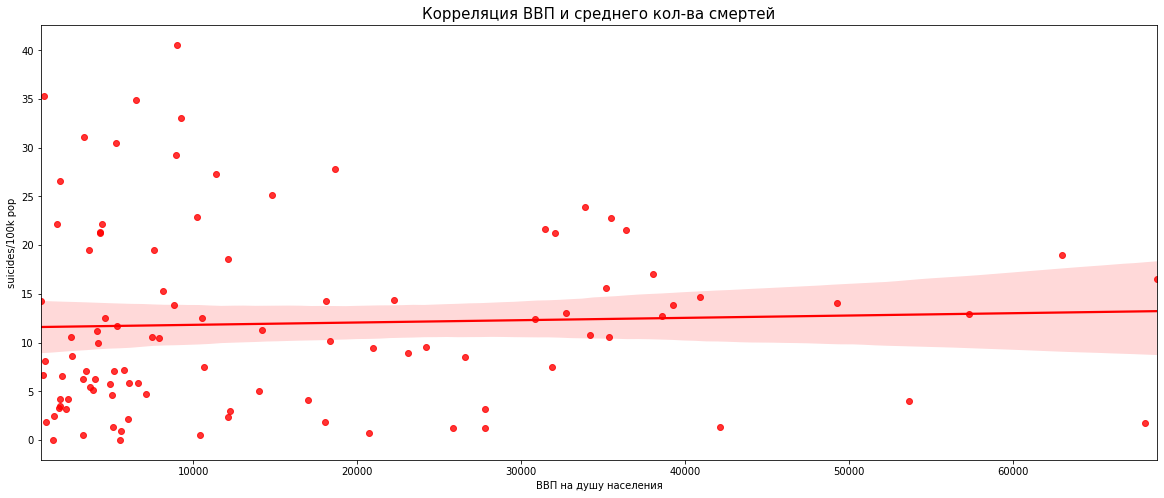

In [47]:
fig = plt.figure(figsize=(20,8))
ax = sns.regplot(x='gdp_per_capita ($)', y ='suicides/100k pop', data=df1, color='red')
plt.title('Корреляция ВВП и среднего кол-ва смертей',fontsize=15)
plt.xlabel('ВВП на душу населения')

In [48]:
df.to_csv('master.csv')

Text(0.5, 0, 'ВВП на душу населения')

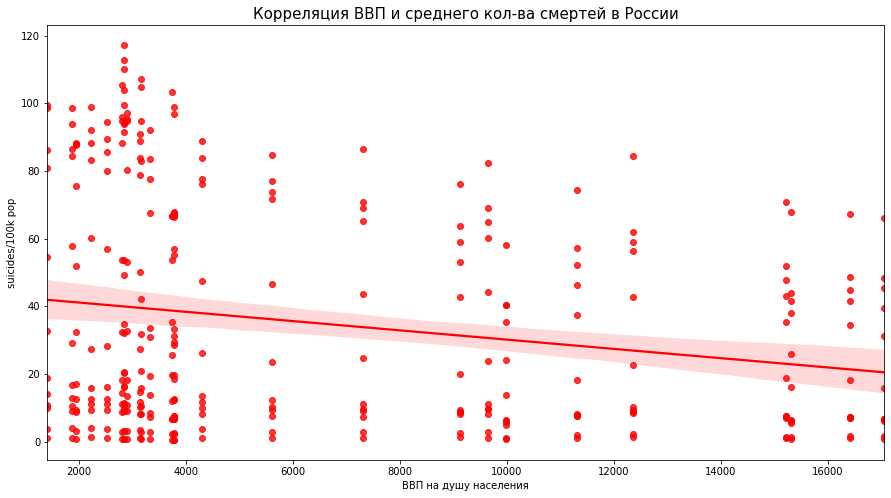

In [56]:
fig = plt.figure(figsize=(15,8))
df3 = df[df['country'] == 'Russian Federation']
ax = sns.regplot(x='gdp_per_capita ($)', y ='suicides/100k pop', data=df3, color='red')
plt.title('Корреляция ВВП и среднего кол-ва смертей в России',fontsize=15)
plt.xlabel('ВВП на душу населения')

Text(0.5, 0, 'ВВП на душу населения')

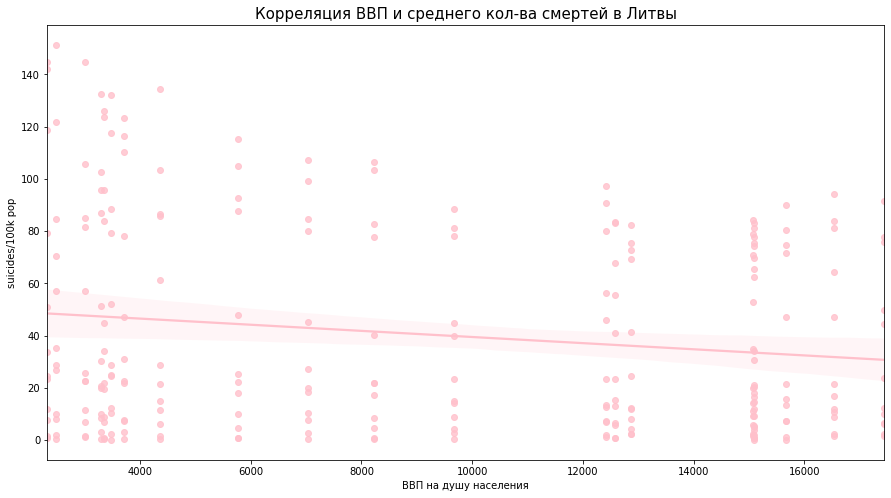

In [57]:
fig = plt.figure(figsize=(15,8))
df3 = df[df['country'] == 'Lithuania']
ax = sns.regplot(x='gdp_per_capita ($)', y ='suicides/100k pop', data=df3, color='pink')
plt.title('Корреляция ВВП и среднего кол-ва смертей в Литвы',fontsize=15)
plt.xlabel('ВВП на душу населения')

Text(0.5, 0, 'ВВП на душу населения')

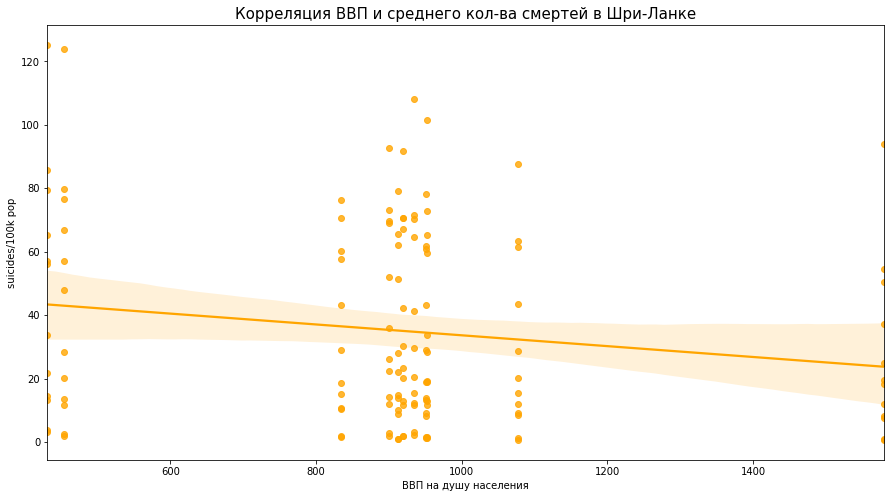

In [58]:
fig = plt.figure(figsize=(15,8))
df3 = df[df['country'] == 'Sri Lanka']
ax = sns.regplot(x='gdp_per_capita ($)', y ='suicides/100k pop', data=df3, color='orange')
plt.title('Корреляция ВВП и среднего кол-ва смертей в Шри-Ланке',fontsize=15)
plt.xlabel('ВВП на душу населения')

Text(0.5, 0, 'ВВП на душу населения')

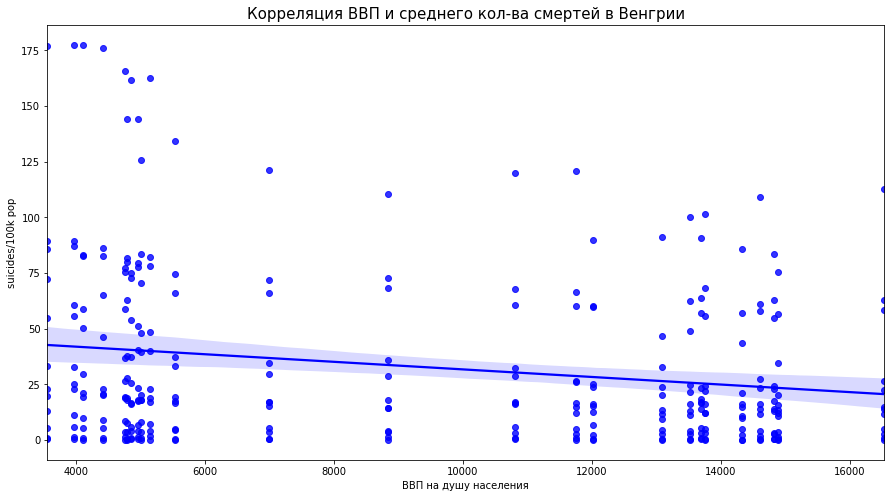

In [59]:
fig = plt.figure(figsize=(15,8))
df3 = df[df['country'] == 'Hungary']
ax = sns.regplot(x='gdp_per_capita ($)', y ='suicides/100k pop', data=df3, color='blue')
plt.title('Корреляция ВВП и среднего кол-ва смертей в Венгрии',fontsize=15)
plt.xlabel('ВВП на душу населения')

Text(0.5, 0, 'ВВП на душу населения')

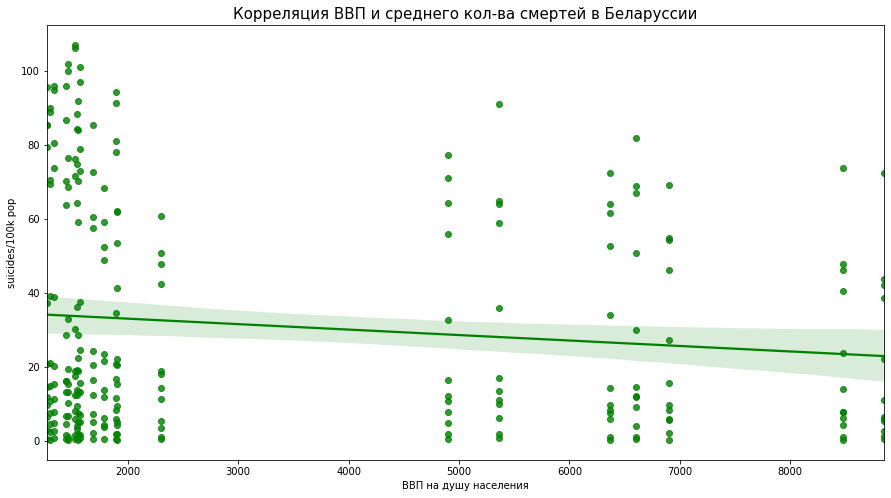

In [60]:
fig = plt.figure(figsize=(15,8))
df3 = df[df['country'] == 'Belarus']
ax = sns.regplot(x='gdp_per_capita ($)', y ='suicides/100k pop', data=df3, color='green')
plt.title('Корреляция ВВП и среднего кол-ва смертей в Беларуссии',fontsize=15)
plt.xlabel('ВВП на душу населения')